In [1]:
from stats2024.data_loader import load 

import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('dark_background')
import seaborn as sns
import pandas as pd 
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

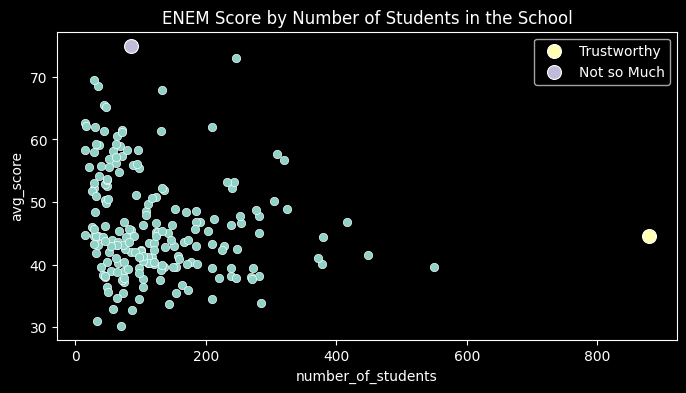

In [2]:
np.random.seed(876)
enem = pd.read_csv("data/enem_scores.csv").sample(200)
plt.figure(figsize=(8,4))
sns.scatterplot(y="avg_score", x="number_of_students", data=enem)
sns.scatterplot(y="avg_score", x="number_of_students", s=100, label="Trustworthy",
                data=enem.query(f"number_of_students=={enem.number_of_students.max()}"))
sns.scatterplot(y="avg_score", x="number_of_students", s=100, label="Not so Much",
                data=enem.query(f"avg_score=={enem.avg_score.max()}"))
plt.title("ENEM Score by Number of Students in the School");

In [3]:
wage = pd.read_csv("data/wage.csv")[["wage", "lhwage", "educ", "IQ"]]

wage.head()

,wage,lhwage,educ,IQ
0,769,2.956212,12,93
1,808,2.782539,18,119
2,825,3.026504,14,108
3,650,2.788093,12,96
4,562,2.642622,11,74


In [9]:
len(wage)

935

In [7]:
model_1 = smf.ols('lhwage ~ educ', data=wage).fit()
model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2954,0.089,25.754,0.000,2.121,2.470
educ,0.0529,0.007,8.107,0.000,0.040,0.066


For practice, group on years of wage:

In [8]:
group_wage = (wage
              .assign(count=1)
              .groupby("educ")
              .agg({"lhwage":"mean", "count":"count"})
              .reset_index())

group_wage

,educ,lhwage,count
0,9,2.856475,10
1,10,2.786911,35
2,11,2.855997,43
3,12,2.922168,393
4,13,3.021182,85
5,14,3.042352,77
6,15,3.090766,45
7,16,3.176184,150
8,17,3.246566,40
9,18,3.144257,57


In [10]:
# weight the linear regression by size of group
model_2 = smf.wls('lhwage ~ educ', data=group_wage, weights=group_wage["count"]).fit()
model_2.summary().tables[1]

/Users/ferguscurrie/Library/Caches/pypoetry/virtualenvs/stats2024-Uuu5pdkl-py3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2954,0.078,29.327,0.000,2.115,2.476
educ,0.0529,0.006,9.231,0.000,0.040,0.066


In [11]:
model_3 = smf.ols('lhwage ~ educ', data=group_wage).fit()
model_3.summary().tables[1]

/Users/ferguscurrie/Library/Caches/pypoetry/virtualenvs/stats2024-Uuu5pdkl-py3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3650,0.082,28.988,0.000,2.177,2.553
educ,0.0481,0.006,8.136,0.000,0.034,0.062


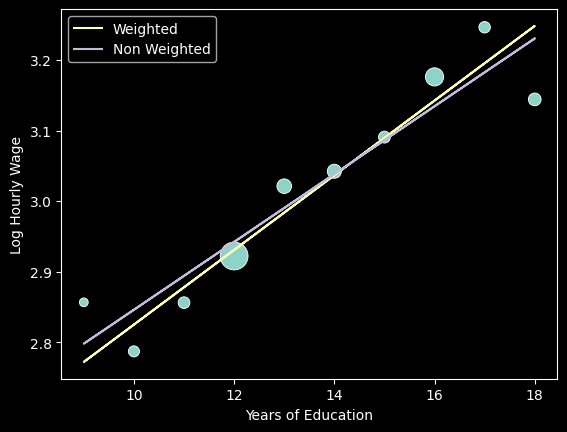

In [12]:
sns.scatterplot(x="educ", y = "lhwage", size="count", legend=False, data=group_wage, sizes=(40, 400))
plt.plot(wage["educ"], model_2.predict(wage["educ"]), c="C1", label = "Weighted")
plt.plot(wage["educ"], model_3.predict(wage["educ"]), c="C2", label = "Non Weighted")
plt.xlabel("Years of Education")
plt.ylabel("Log Hourly Wage")
plt.legend();

# Dummy

T is educ years greaterthan 12

In [15]:
wage = (pd.read_csv("./data/wage.csv")
        .assign(hwage=lambda d: d["wage"] / d["hours"])
        .assign(T=lambda d: (d["educ"] > 12).astype(int)))

wage[["hwage", "IQ", "T"]].head()

,hwage,IQ,T
0,19.225,93,0
1,16.160,119,1
2,20.625,108,1
3,16.250,96,0
4,14.050,74,0


In [16]:
smf.ols('hwage ~ T', data=wage).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,19.9405,0.436,45.685,0.000,19.084,20.797
T,4.9044,0.626,7.830,0.000,3.675,6.134


Predicts intercept when T=0, predicts intercept + T_coeff when T=1. Do dummy coeffcient captures difference in means between T=0 and T= 1

In this single variable case the effect of T is the conditinal expectation function. However if we add more variables it becomes oniditoned on the othervariable being held constant:

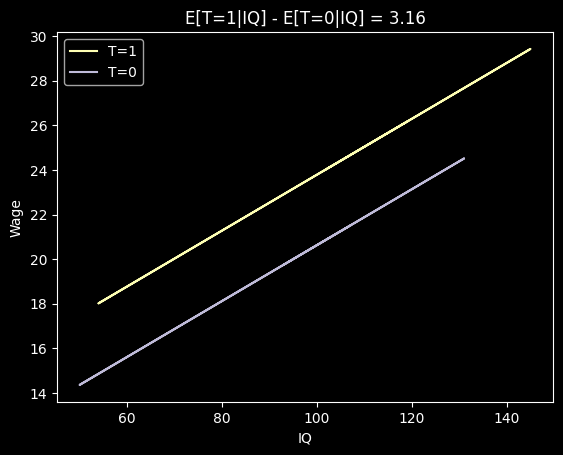

In [17]:
m = smf.ols('hwage ~ T+IQ', data=wage).fit()
plt_df = wage.assign(y_hat = m.fittedvalues)

plt.plot(plt_df.query("T==1")["IQ"], plt_df.query("T==1")["y_hat"], c="C1", label="T=1")
plt.plot(plt_df.query("T==0")["IQ"], plt_df.query("T==0")["y_hat"], c="C2", label="T=0")
plt.title(f"E[T=1|IQ] - E[T=0|IQ] = {round(m.params['T'], 2)}")
plt.ylabel("Wage")
plt.xlabel("IQ")
plt.legend();

## Interaction

$wage_i = \beta_0 + \beta_1 T_i + \beta_2 IQ_i + \beta_3IQ_i*T_i + e_i$

Interpretations: 
- $\beta_0$ is the intercept. the wage when iq=0 and T=0
- $\beta_1$ which is expected increase in wage if T=1 given IQ=0
- $\beta_2$ which is increase in wages for the non-treated
- $\beta_3$ how much IQ increases the effect of T=1

An interaction term allows the effect to change accross levels of an axuilary variable. Referedded to as an effect modification or hetrogenous treament effect. 
  

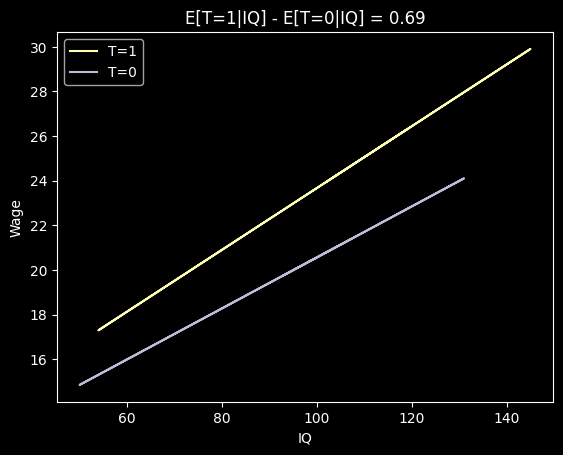

In [18]:
m = smf.ols('hwage ~ T*IQ', data=wage).fit()
plt_df = wage.assign(y_hat = m.fittedvalues)

plt.plot(plt_df.query("T==1")["IQ"], plt_df.query("T==1")["y_hat"], c="C1", label="T=1")
plt.plot(plt_df.query("T==0")["IQ"], plt_df.query("T==0")["y_hat"], c="C2", label="T=0")
plt.title(f"E[T=1|IQ] - E[T=0|IQ] = {round(m.params['T'], 2)}")
plt.ylabel("Wage")
plt.xlabel("IQ")
plt.legend();

Now dummy everything 

In [22]:
wage_ed_bins = (wage
                .assign(IQ_bins = lambda d: pd.qcut(d["IQ"], q=4, labels=range(4)))
                [["hwage", "educ", "IQ_bins"]])

wage_ed_bins.head()

,hwage,educ,IQ_bins
0,19.225,12,1
1,16.160,18,3
2,20.625,14,2
3,16.250,12,1
4,14.050,11,0


In [20]:
model_dummy = smf.ols('hwage ~ C(educ)', data=wage).fit()
model_dummy.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,18.5600,3.011,6.164,0.000,12.651,24.469
C(educ)[T.10],-0.7874,3.414,-0.231,0.818,-7.488,5.913
C(educ)[T.11],0.1084,3.343,0.032,0.974,-6.452,6.669
C(educ)[T.12],1.7479,3.049,0.573,0.567,-4.236,7.732
C(educ)[T.13],4.3290,3.183,1.360,0.174,-1.918,10.576
C(educ)[T.14],4.0888,3.200,1.278,0.202,-2.192,10.370
C(educ)[T.15],6.3013,3.329,1.893,0.059,-0.231,12.834
C(educ)[T.16],7.2225,3.110,2.323,0.020,1.120,13.325
C(educ)[T.17],9.5905,3.366,2.849,0.004,2.984,16.197
C(educ)[T.18],7.3681,3.264,2.257,0.024,0.962,13.775


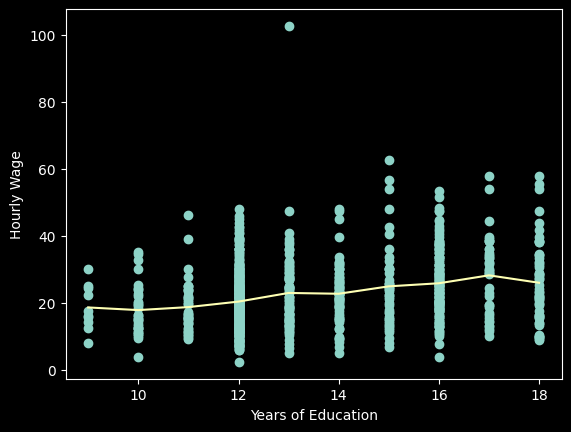

In [21]:
plt.scatter(wage["educ"], wage["hwage"])
plt.plot(wage["educ"].sort_values(), model_dummy.predict(wage["educ"].sort_values()), c="C1")
plt.xlabel("Years of Education")
plt.ylabel("Hourly Wage");